# Keras ResNet50 Feature Extraction #

### Importing necessary libraries and modules ###

In [1]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import os

### Define the function to extract features ###

In [2]:
def extract_features(model, folder_path):
    """
    Extract features from images using a pre-trained model.

    Args:
    - model (tensorflow.keras.models.Model): Pre-trained model for feature extraction.
    - folder_path (str): Path to the folder containing image files.

    Returns:
    - features (numpy.ndarray): Extracted features from images.
    """
    # Get a list of all image files in the folder
    img_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Use list comprehension to process images and extract features
    features = []
    for img_path in img_paths:
        try:
            img = image.load_img(img_path, target_size=model.input_shape[1:3])
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)
            feature = model.predict(img_array)
            features.append(feature)
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

    # Stack the extracted features into a single NumPy array
    features = np.vstack(features)

    return features


### Load the pre-trained ResNet50 model and create a new model with convolutional base only ###

In [3]:
# Load the pre-trained ResNet50 model with top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=True, input_shape=(224, 224, 3)) # Adjust input_shape accordingly

# Create a new model that includes only the convolutional base of ResNet50
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)


### Specify folder paths for ASD and non-ASD child face image sets ###

In [6]:
# Specify folder paths for ASD and non-ASD child face image sets
asd_folder_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD'
non_asd_folder_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/NON-ASD'

### Extract features for ASD child faces ###

In [7]:
# Extract features for ASD child faces
asd_features = extract_features(model, asd_folder_path)

1/1 [==============================] - 0s 101ms/step


### Extract features for non-ASD child faces ###

In [8]:
# Extract features for non-ASD child faces
non_asd_features = extract_features(model, non_asd_folder_path)

1/1 [==============================] - 0s 72ms/step
Error processing image /Users/isurudissanayake/Documents/Data/DATA_SET/NON-ASD/child-1617.png: cannot identify image file <_io.BytesIO object at 0x295629c70>
1/1 [==============================] - 0s 78ms/step
Error processing image /Users/isurudissanayake/Documents/Data/DATA_SET/NON-ASD/additional1178.png: cannot identify image file <_io.BytesIO object at 0x13e69d9a0>
1/1 [==============================] - 0s 72ms/step


### Save the extracted features for later use in training ###

In [9]:
# Save the extracted features for later use in training
np.save('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/ResNet50/asd_features.npy', asd_features)
np.save('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/ResNet50/non_asd_features.npy', non_asd_features)

# Keras ResNet50 Model Training #

### Importing necessary libraries ###

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
from sklearn.model_selection import train_test_split

### Load the extracted features ###

In [12]:
asd_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/ResNet50/asd_features.npy')
non_asd_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/ResNet50/non_asd_features.npy')

### Create labels for ASD (1) and non-ASD (0) samples ###

In [13]:
asd_labels = np.ones(asd_features.shape[0])
non_asd_labels = np.zeros(non_asd_features.shape[0])

### Concatenate features and labels ###

In [14]:
X = np.concatenate([asd_features, non_asd_features], axis=0)
y = np.concatenate([asd_labels, non_asd_labels])

### Split the data into training and testing sets ###

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Build a simple neural network ###

In [16]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

### Compile the model ###

In [17]:
model.compile(optimizer=LegacyAdam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

### Train the model ###

In [18]:
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
250/250 [==============================] - 1s 1ms/step - loss: 0.2413 - accuracy: 0.9046 - val_loss: 0.1572 - val_accuracy: 0.9344
Epoch 2/100
250/250 [==============================] - 0s 1ms/step - loss: 0.1668 - accuracy: 0.9332 - val_loss: 0.1337 - val_accuracy: 0.9494
Epoch 3/100
250/250 [==============================] - 0s 1ms/step - loss: 0.1390 - accuracy: 0.9449 - val_loss: 0.1266 - val_accuracy: 0.9464
Epoch 4/100
250/250 [==============================] - 0s 1ms/step - loss: 0.1248 - accuracy: 0.9523 - val_loss: 0.1192 - val_accuracy: 0.9539
Epoch 5/100
250/250 [==============================] - 0s 1ms/step - loss: 0.1123 - accuracy: 0.9546 - val_loss: 0.1215 - val_accuracy: 0.9514
Epoch 6/100
250/250 [==============================] - 0s 1ms/step - loss: 0.1082 - accuracy: 0.9568 - val_loss: 0.1554 - val_accuracy: 0.9384
Epoch 7/100
250/250 [==============================] - 0s 1ms/step - loss: 0.0956 - accuracy: 0.9645 - val_loss: 0.1139 - val_accuracy: 0.9559

### Evaluate the model on the test set ###

In [19]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

63/63 [==============================] - 0s 524us/step - loss: 0.2259 - accuracy: 0.9549
Test Accuracy: 0.9549098014831543


### Save the model for later use ###

In [20]:
model.save('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/ResNet50/ResNet50Model.h5')

# Keras ResNet50 Prediction #

### Import necessary libraries ###

In [21]:
import cv2
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model, load_model

### Define paths ###

In [22]:
input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0576.jpg' # Replace with your image path
model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/ResNet50/ResNet50Model.h5'
target_size = (224, 224)

### Load the pre-trained ResNet50 model ###

In [23]:
base_model = ResNet50(weights='imagenet', include_top=True)

### Create a new model that takes the input of ResNet50 and outputs the desired layer ###

In [24]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

### Process the input image ###

In [25]:
img = cv2.imread(input_image_path)
img = cv2.resize(img, target_size)
img = preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))

### Extract features using the full ResNet50 model ###

In [26]:
features = model.predict(img)  # Use the new model

1/1 [==============================] - 1s 644ms/step


### Reshape features to match the expected input shape of trained_model ###

In [27]:
features_reshaped = np.reshape(features, (1, 2048))  # Reshape to (1, 7, 7, 512)

### Load the trained model ###

In [28]:
trained_model = load_model(model_path)

### Predict ASD probability using the trained model and extracted features ###

In [29]:
prediction = trained_model.predict(features_reshaped)[0][0]  # Access the first element for ASD probability

1/1 [==============================] - 0s 26ms/step


### Print prediction ###

In [30]:
print("Prediction:", prediction)

Prediction: 0.9999992


### Format prediction to display only 5 decimal places ###

In [31]:
formatted_prediction = "{:.5f}".format(prediction)
print("Formatted Prediction:", formatted_prediction)

Formatted Prediction: 1.00000


### Round prediction to 2 decimal places ###

In [32]:
rounded_prediction = round(prediction, 2)
print("Rounded Prediction:", rounded_prediction)

Rounded Prediction: 1.0


### Determine and print the predicted class based on the threshold ###

In [33]:
if rounded_prediction > 0.5:
    print("Predicted ASD with probability:", rounded_prediction)
else:
    print("Predicted non-ASD with probability:", 1 - rounded_prediction)

Predicted ASD with probability: 1.0


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model, load_model
from lime.lime_image import LimeImageExplainer
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Define paths
input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0576.jpg' # Replace with your image path
model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/ResNet50/ResNet50Model.h5'
target_size = (224, 224)

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=True)

x = base_model.get_layer('avg_pool').output
x = Dense(2048, activation='relu')(x)
x = Reshape((1, 1, 2048))(x) # Add this line to reshape the output of GlobalAveragePooling2D
x = GlobalAveragePooling2D()(x)
prediction = Dense(1, activation='sigmoid')(x)

# Create a new model that takes the input of ResNet50 and outputs the desired layer
model = Model(inputs=base_model.input, outputs=prediction)

# Process the input image
img = cv2.imread(input_image_path)
img = cv2.resize(img, target_size)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

img_scaled = img / 255.0

# Predict ASD probability using the trained model and extracted features
prediction = model.predict(img)[0][0]  # Access the first element for ASD probability
print("prediction: {:.5f}".format(prediction))

rounded_prediction = round(prediction, 2)
print(f"Predicted probability: {rounded_prediction:.2f}")

if rounded_prediction > 0.5:
    print(f"Predicted ASD with probability: {rounded_prediction:.2f}")

    # Explain the prediction using LIME
    explainer = LimeImageExplainer()

    # Generate an explanation for the prediction using the explainer object
    explanation = explainer.explain_instance(img_scaled[0], model.predict, top_labels=1, hide_color=0,
                                             num_samples=10000, random_seed=42)

    # Visualize the explanation using matplotlib
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5,
                                                hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.show()

else:
    print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")

1/1 [==============================] - 1s 610ms/step
prediction: 0.71437
Predicted probability: 0.71
Predicted ASD with probability: 0.71


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 830ms/step


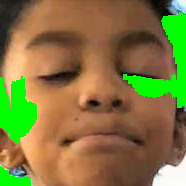

In [34]:
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model, load_model
from lime.lime_image import LimeImageExplainer
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Define paths
input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0576.jpg' # Replace with your image path
model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/ResNet50/ResNet50Model.h5'
target_size = (224, 224)

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=True)

x = base_model.get_layer('avg_pool').output
x = Dense(2048, activation='relu')(x)
x = Reshape((1, 1, 2048))(x) # Add this line to reshape the output of GlobalAveragePooling2D
x = GlobalAveragePooling2D()(x)
prediction = Dense(1, activation='sigmoid')(x)

# Create a new model that takes the input of ResNet50 and outputs the desired layer
model = Model(inputs=base_model.input, outputs=prediction)

# Process the input image
img = cv2.imread(input_image_path)
img = cv2.resize(img, target_size)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

img_scaled = img / 255.0

# Predict ASD probability using the trained model and extracted features
prediction = model.predict(img)[0][0]  # Access the first element for ASD probability
print("prediction: {:.5f}".format(prediction))

rounded_prediction = round(prediction, 2)
print(f"Predicted probability: {rounded_prediction:.2f}")

if rounded_prediction > 0.5:
    print(f"Predicted ASD with probability: {rounded_prediction:.2f}")

    explainer = LimeImageExplainer()

    # Generate an explanation for the prediction using the explainer object
    explanation = explainer.explain_instance(img_scaled[0], model.predict, top_labels=1, hide_color=0, num_samples=10000, random_seed=42)

    # Visualize the explanation using matplotlib
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

    # Resize the explanation mask to match the original image dimensions
    mask = cv2.resize(mask, (target_size[0], target_size[1]), interpolation=cv2.INTER_NEAREST)

    # Convert the mask to the original image mode
    original_image = Image.open(input_image_path)
    #original_image = original_image.convert("L")  # Convert the original image to grayscale
    original_width, original_height = original_image.size
    original_mode = original_image.mode

    # Overlay the explanation mask on the original image
    mask = cv2.resize(mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)
    original_image = np.array(original_image)
    original_image[mask > 0.5] = (0, 255, 0)



    # Display the original image with the explanation mask
    display(Image.fromarray(original_image))

else:
    print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")